## Decode 3D hand movements from spiking data - Summary of model and results

#### Data
I use spiking data from 175 neurons to predict hand movements in 3D dimensions.
1. Neural Data: recorded from a Utah Array implanted in sensorimotor cortex of a common marmoset. Spike counts are binned in 20ms windows.
2. Kinematic Data: 3D hand position, which was estimated from video data using DeepLabCut. 
3. Experimental Behavior: the marmoset is capturing live moths in a prey-capture box. 

#### Models
I implement an LSTM model to predict instananeous position of the hand in 3D from spike count data in 175 neurons. I define a sequence length and decoder lead time such that the specified time bins of neural activity predict movement a short time later (50ms). There is also a linear readout layer after the LSTM layer to convert outputs from the LSTM to x-y-z position. I used this paper cited below as a guide for designing and implementing the model: 

Liu, Fangyu, et al. "Deep learning for neural decoding in motor cortex." Journal of Neural Engineering 19.5 (2022): 056021.  

#### I started with a relatively simple LSTM model:
1. Hidden layers: 1
2. Units in hidden layer: 32
3. Dropout: 0.0
4. Weight decay: 0
5. Momentum: 0
6. lr = 0.001 (SGD)
7. Sequence length = 100 ms
8. Decoder lead time = 50 ms 
9. Epochs: 100

Results on test data: r2 = 0.79

#### After some iteration, I found the best model performance for a model with the following parameters:
1. Hidden layers: 2
2. Units in hidden layers: 64
3. Dropout: 0.4
4. Weight decay: 1e-5
5. Momentum: 0
6. lr = 0.01 (SGD)
7. Sequence length = 150 ms
8. Decoder lead time = 50 ms 
9. Epochs: 30 

Results on test data: r2 = 0.86

#### To-do
Although I have improved on the initial model, there are more things to be done:
1. Create custom Dataset and Dataloader classes. Right now, I input single bin position samples and the sequence of spikes related to that sample sequentially. I should train in batches, with members of each batch sampled randomly from the training set. 
2. Use k-Fold cross validation.
3. Test batch normalization.
4. Programmatically optimize hyperparameters on validation sets before testing on held-out test data.
5. Also evaluate range of decoder lead times and sequence lengths.
6. Isolate best subset of neurons for inputs to the model. I know how strongly each neuron is related to kinematic data from encoding models I have implemented on this dataset in my research. I could use this to select the neurons that are most informative.
7. The validation loss is much higher than the training loss for every model variation I've tested. Should look into ways to more strongly regularize the model. Might improve test performance by disrupting temporal structure of training data as described in a recent preprint: 

    Deo DR, et al. Translating deep learning to neuroprosthetic control. bioRxiv 2023.04.21.537581
    
8. Finally, I should learn to implement this project (and others) using PyTorch-Lightning.


#### Imports and data selection parameters

In [385]:
import torch
from torch import nn

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output
from itertools import product
from tqdm import trange
from pathlib import Path

data_path = Path('../data')
h5_datafile = data_path / 'movement_data.h5' 

bin_ms = 20 
sequence_time_ms = 150
decoder_lead_time_ms = 50
sequence_bins = int(sequence_time_ms / bin_ms) 
decoder_lead_bins = int(decoder_lead_time_ms / bin_ms)

device = "cuda" if torch.cuda.is_available() else "cpu"

#### Load and split data

In [359]:
reach_pos_and_spikes = pd.read_hdf(h5_datafile, f'reach_pos_and_spikes_{bin_ms}ms_bins')

spikes_train_val, spikes_test, pos_train_val, pos_test = train_test_split(reach_pos_and_spikes['spikes'], reach_pos_and_spikes['position'], test_size=0.20, random_state=41,shuffle=True)
spikes_train, spikes_val, pos_train, pos_val           = train_test_split(spikes_train_val, pos_train_val, test_size=0.20, random_state=42,shuffle=True)

num_neurons = reach_pos_and_spikes.loc[0, 'spikes'].shape[0]
spikes_t0_bin = reach_pos_and_spikes.loc[0, 'spikes'].shape[1] - reach_pos_and_spikes.loc[0, 'position'].shape[1] 

#### Functions for preparing and plotting data, and for evaluating the model

In [360]:
def prepare_single_trial_data(trial_spikes, trial_position, sequence_bins, decoder_lead_bins, spikes_t0_bin, device):
    spikes_list   = []
    position_list = []
    
    for pos_bin in range(trial_position.shape[-1]):
        
        if np.all(np.isnan(trial_position[0, pos_bin:])):
            break
        
        spikes_bin = pos_bin + spikes_t0_bin
        tmp_spks = trial_spikes[:, spikes_bin - sequence_bins - decoder_lead_bins : spikes_bin - decoder_lead_bins +1]
        tmp_spks = tmp_spks.T

        tmp_pos  = trial_position[:, pos_bin]

        spikes_list.append(  torch.tensor(tmp_spks, dtype=torch.float32).to(device))
        position_list.append(torch.tensor(tmp_pos , dtype=torch.float32).to(device))    

    return spikes_list, position_list

In [382]:
def plot_pred_vs_true_pos(position_pred, position_true, trial_r2, data_group, reach_num):
    times = np.arange(0, position_true.shape[1]*bin_ms, bin_ms)
    
    fig, ax = plt.subplots()
    ax.plot(times, position_true[0] + 20, '-k', label='x')
    ax.plot(times, position_pred[0] + 20, '-.k', label='Predicted x')
    ax.plot(times,position_true[1], '-b', label='y')
    ax.plot(times,position_pred[1], '-.b', label='Predicted y')
    ax.plot(times,position_true[2] - 5, '-g', label='z')
    ax.plot(times,position_pred[2] - 5, '-.g', label='Predicted z')
    ax.set_title(f'{data_group} set, reach number {reach_num}, r2 = {trial_r2:.2f}')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Position (cm)')
    ax.legend(bbox_to_anchor = (1.1, .75))
    plt.show()


In [362]:
def predict_single_trial_position(model, eval_dict, sequence_bins, decoder_lead_bins, spikes_t0_bin, device, plot=False):

    spks_arr = eval_dict['spikes'].iloc[eval_dict['idx']]
    pos_arr  = eval_dict['position'].iloc[eval_dict['idx']]
    data_group = eval_dict['group']
    reach_num = eval_dict['spikes'].index[eval_dict['idx']]

    model.eval()
    with torch.inference_mode():
        spikes_list, position_list = prepare_single_trial_data(spks_arr, 
                                                               pos_arr,
                                                               sequence_bins=sequence_bins,
                                                               decoder_lead_bins=decoder_lead_bins,
                                                               spikes_t0_bin=spikes_t0_bin,
                                                               device=device)
        
        position_pred = np.full_like(pos_arr, np.nan)
        for bin, (spks, pos) in enumerate(zip(spikes_list, position_list)):
            pos_out_tensor = model(spks)
            position_pred[:, bin] = pos_out_tensor.cpu().numpy()

        good_idxs = np.where(~np.isnan(pos_arr.flatten()))[0] 
        trial_r2 = r2_score(pos_arr.flatten()[good_idxs], position_pred.flatten()[good_idxs])

        if plot:
            plot_pred_vs_true_pos(position_pred, pos_arr, trial_r2, data_group, reach_num)

    return trial_r2

In [363]:
def test_set_performance(model, spikes_test, pos_test, sequence_bins, decoder_lead_bins, spikes_t0_bin, device, plot=True):
    all_trials_r2 = np.full((spikes_test.shape[0],), np.nan)   
    nsamples_arr = np.full_like(all_trials_r2, np.nan)
    for idx in range(spikes_test.shape[0]): 
        eval_dict = dict(group='test', idx=idx, spikes=spikes_test, position=pos_test)
        trial_r2 = predict_single_trial_position(model, 
                                                eval_dict, 
                                                sequence_bins, 
                                                decoder_lead_bins,
                                                spikes_t0_bin, 
                                                device, 
                                                plot=plot)

        all_trials_r2[idx] = trial_r2 
        nsamples_arr[idx]  = (~np.isnan(pos_test.iloc[idx])).sum()

    combined_r2 = (all_trials_r2 * nsamples_arr).sum() / nsamples_arr.sum()

    return combined_r2

#### Setup the class for the LSTM model and the training function

In [365]:
class LSTM_position_decoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers=1, dropout=0.0):
        super(LSTM_position_decoder, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_size  = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers  = num_layers,  
                            dropout     = dropout)

        # The linear layer that maps from hidden state space to 3D position
        self.hidden2pos = nn.Linear(hidden_dim, 3, device=device)

    def forward(self, spikes):
        lstm_out, _  = self.lstm(spikes)
        position_out = self.hidden2pos(lstm_out[-1])
        return position_out

In [ ]:
def train_model(model, spikes_train, pos_train, spikes_val, pos_val, 
                sequence_bins, decoder_lead_bins, spikes_t0_bin, device,
                loss_function, optimizer, epochs=5, print_res=True):
    
    tloss = [[] for e in range(epochs)] 
    vloss = [[] for e in range(epochs)] 
    for epoch in range(epochs): 
        #-----------------------------------------------------------------------
        # Training Step
        #-----------------------------------------------------------------------
        model.train()

        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0

        for trial, (spks_arr, pos_arr) in enumerate(zip(spikes_train.values, pos_train.values)):

            spikes_list, position_list = prepare_single_trial_data(spks_arr, 
                                                               pos_arr,
                                                               sequence_bins=sequence_bins,
                                                               decoder_lead_bins=decoder_lead_bins,
                                                               spikes_t0_bin=spikes_t0_bin,
                                                               device=device)

            for bin, (spks, position_true) in enumerate(zip(spikes_list, position_list)):
                # print(f'epoch = {epoch}, trial = {trial}, bin = {bin}')
                
                if position_true.isnan().sum() > 0:
                     continue
                
                # if trial == 3 and bin == 1:
                #      catchhere = []

                optimizer.zero_grad()
                position_pred = model(spks)

                if position_pred.isnan().sum() > 0:
                     return

                loss = loss_function(position_pred, position_true)
                loss.backward()
                optimizer.step()

                tloss[epoch].append(loss.item())
                y_true_train.extend(list(position_true.cpu().data.numpy().flatten()))
                y_pred_train.extend(list(position_pred.cpu().data.numpy().flatten()))
                total_loss_train += loss.item()

        train_loss = total_loss_train/(spikes_train.shape[0] * len(spikes_list)) 
        train_r2 = r2_score(y_true_train, y_pred_train) 

        #-----------------------------------------------------------------------
        # Validation Step
        #-----------------------------------------------------------------------
        model.eval()
        y_true_val = list()
        y_pred_val = list()
        total_loss_val = 0

        for spks_arr, pos_arr in zip(spikes_val.values, pos_val.values):
            spikes_list, position_list = prepare_single_trial_data(spks_arr, 
                                                               pos_arr,
                                                               sequence_bins=sequence_bins,
                                                               decoder_lead_bins=decoder_lead_bins,
                                                               spikes_t0_bin=spikes_t0_bin,
                                                               device=device)
            for bin, (spks, position_true) in enumerate(zip(spikes_list, position_list)):
                if position_true.isnan().sum() > 0:
                     continue
                position_pred = model(spks)
                loss = loss_function(position_pred, position_true)

                vloss[epoch].append(loss.item())
                y_true_val.extend(list(position_true.cpu().data.numpy().flatten()))
                y_pred_val.extend(list(position_pred.cpu().data.numpy().flatten()))
                total_loss_val += loss.item()

        val_loss = total_loss_val/(spikes_val.shape[0] * len(spikes_list)) 
        val_r2 = r2_score(y_true_val, y_pred_val) 
        if print_res:
                print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_r2: {train_r2:.4f} | val_loss: {val_loss:.4f} val_r2: {val_r2:.4f}')

    return tloss, vloss

#### Initialize model and show example predictions prior to training 

In [387]:
lstm_model = LSTM_position_decoder(input_dim  = num_neurons, 
                                   hidden_dim = 64,
                                   num_layers = 2,
                                   dropout    = 0.4).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(lstm_model.parameters(), lr=0.01, weight_decay=1e-5)

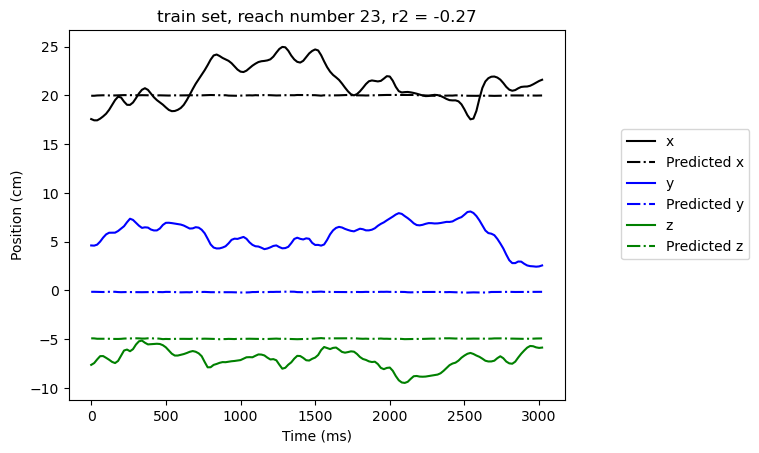

In [388]:

eval_dict = dict(group='train', idx=0, spikes=spikes_train, position=pos_train)
trial_r2 = predict_single_trial_position(lstm_model, 
                                         eval_dict, 
                                         sequence_bins, 
                                         decoder_lead_bins,
                                         spikes_t0_bin, 
                                         device, 
                                         plot=True)

#### Train the model

In [376]:
train_loss, val_loss = train_model(lstm_model, 
                                   spikes_train, 
                                   pos_train, 
                                   spikes_val, 
                                   pos_val, 
                                   sequence_bins, 
                                   decoder_lead_bins,
                                   spikes_t0_bin, 
                                   device,
                                   loss_function, 
                                   optimizer, 
                                   epochs=30, 
                                   print_res=True)


Epoch 0: train_loss: 0.8725 train_r2: 0.9471 | val_loss: 3.4885 val_r2: 0.6956
Epoch 1: train_loss: 0.6531 train_r2: 0.9604 | val_loss: 3.2800 val_r2: 0.7138
Epoch 2: train_loss: 0.6045 train_r2: 0.9633 | val_loss: 2.7317 val_r2: 0.7616
Epoch 3: train_loss: 0.5643 train_r2: 0.9658 | val_loss: 2.7071 val_r2: 0.7638
Epoch 4: train_loss: 0.5729 train_r2: 0.9653 | val_loss: 2.8684 val_r2: 0.7497
Epoch 5: train_loss: 0.5534 train_r2: 0.9664 | val_loss: 2.9573 val_r2: 0.7419
Epoch 6: train_loss: 0.5408 train_r2: 0.9672 | val_loss: 2.4014 val_r2: 0.7904
Epoch 7: train_loss: 0.5415 train_r2: 0.9672 | val_loss: 2.3372 val_r2: 0.7960
Epoch 8: train_loss: 0.5265 train_r2: 0.9681 | val_loss: 2.1795 val_r2: 0.8098
Epoch 9: train_loss: 0.4992 train_r2: 0.9697 | val_loss: 2.2786 val_r2: 0.8012
Epoch 10: train_loss: 0.5032 train_r2: 0.9695 | val_loss: 2.2787 val_r2: 0.8011
Epoch 11: train_loss: 0.5034 train_r2: 0.9695 | val_loss: 2.0107 val_r2: 0.8245
Epoch 12: train_loss: 0.4866 train_r2: 0.9705 | va

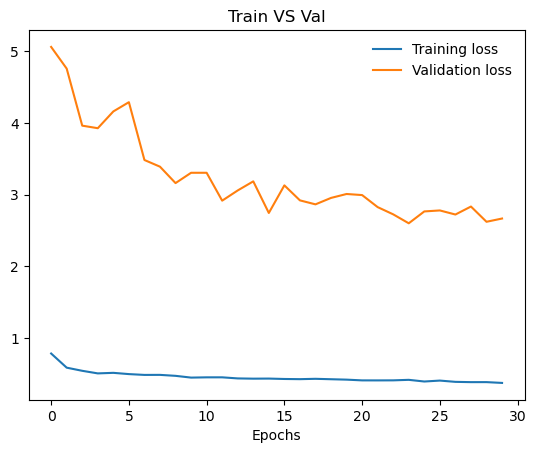

In [377]:
t = [np.mean(train_loss[el]) for el in range(len(train_loss))]
v = [np.mean(val_loss[el]) for el in range(len(val_loss))]

fig, ax = plt.subplots()
ax.plot(t, label='Training loss')
ax.plot(v, label='Validation loss')
ax.set_title(f"Train VS Val")
ax.set_xlabel("Epochs")
ax.legend(frameon=False)
plt.show()

#### Show the model learned to decode movement from spikes on the train set  

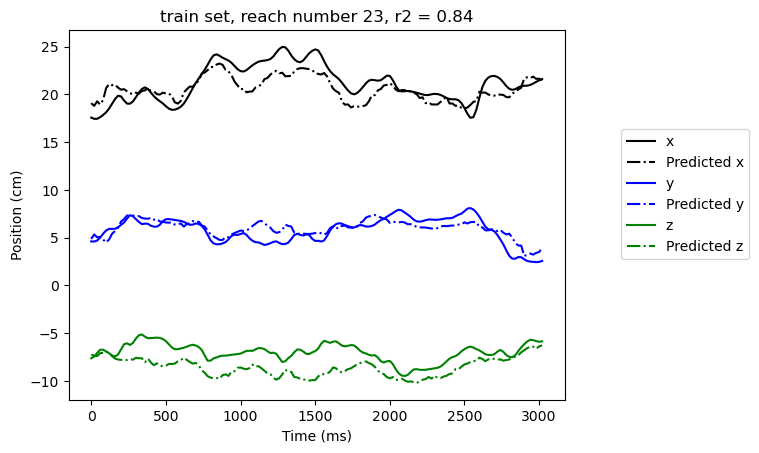

In [383]:
eval_dict = dict(group='train', idx=0, spikes=spikes_train, position=pos_train)
trial_r2 = predict_single_trial_position(lstm_model, 
                                         eval_dict, 
                                         sequence_bins, 
                                         decoder_lead_bins,
                                         spikes_t0_bin, 
                                         device, 
                                         plot=True)

#### Evaluate decoding on held-out test data

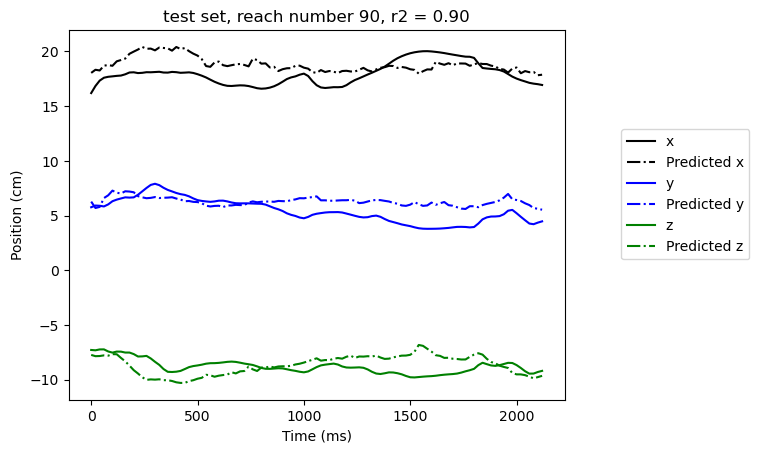

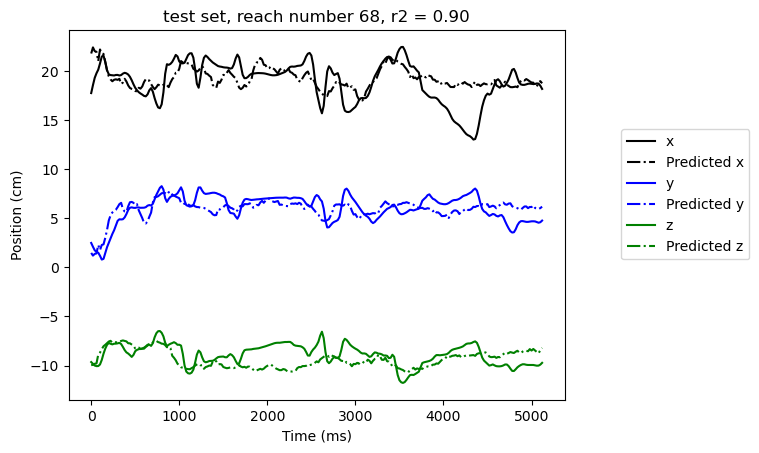

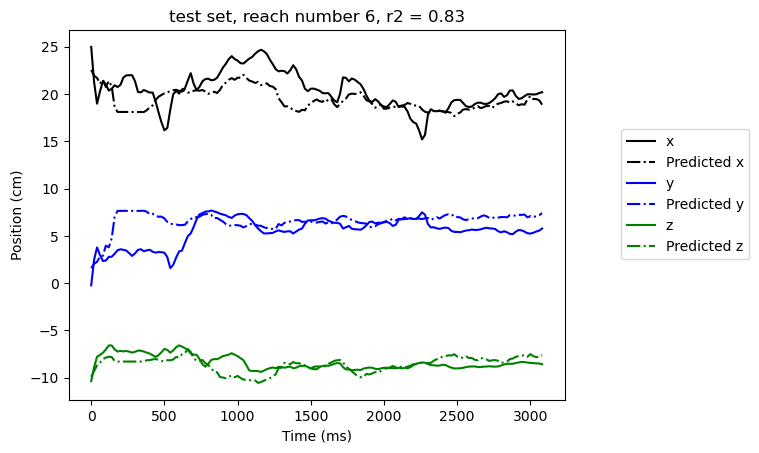

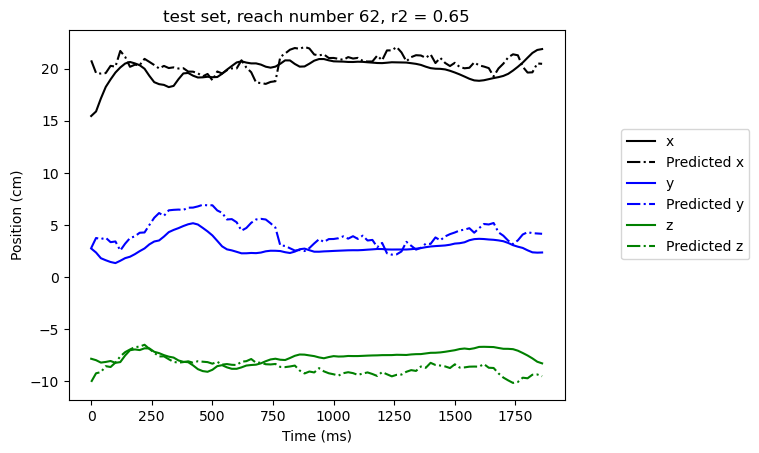

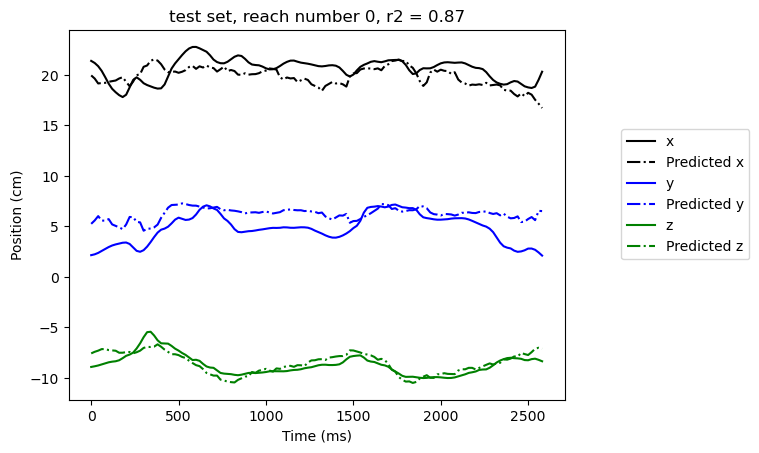

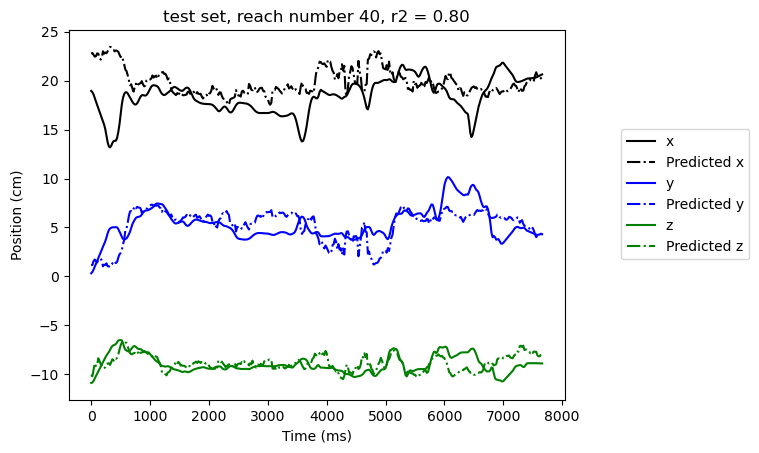

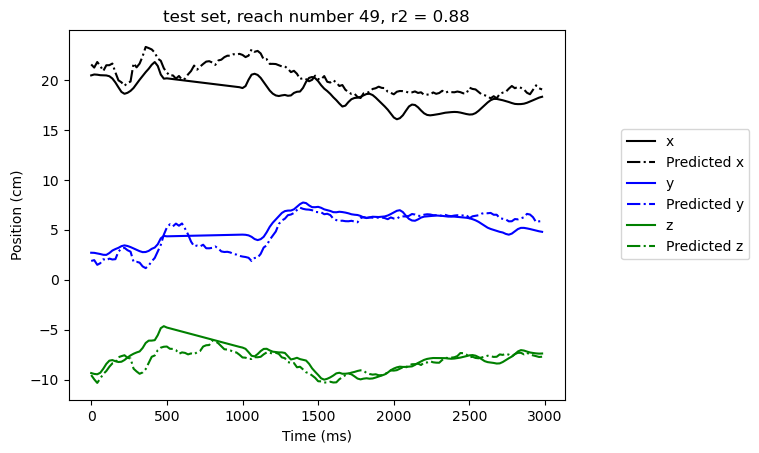

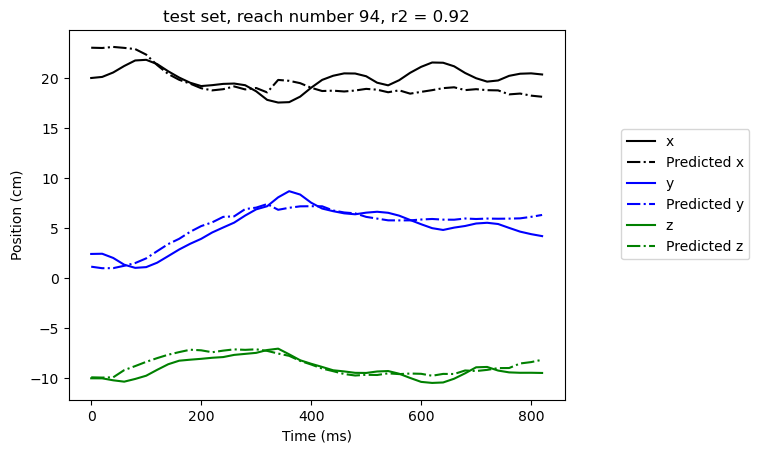

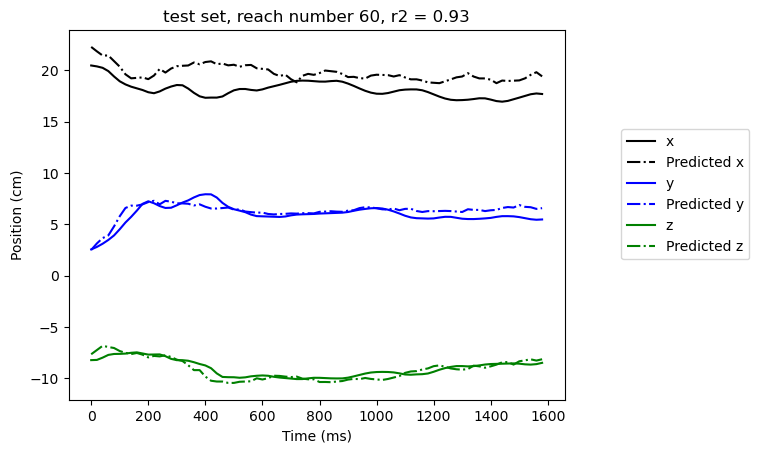

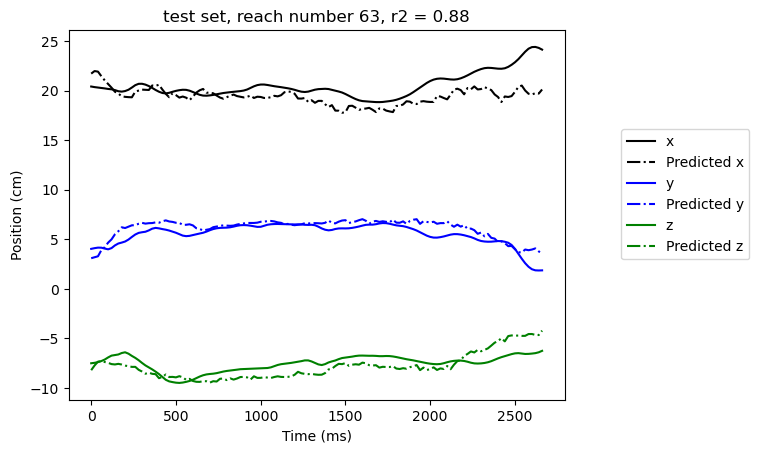

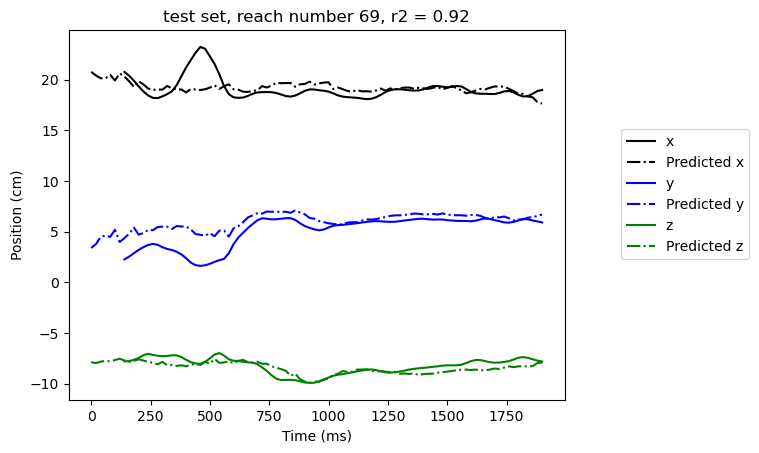

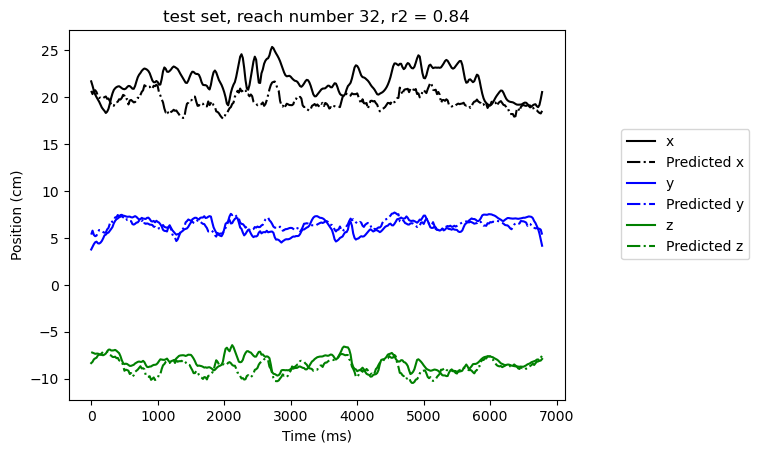

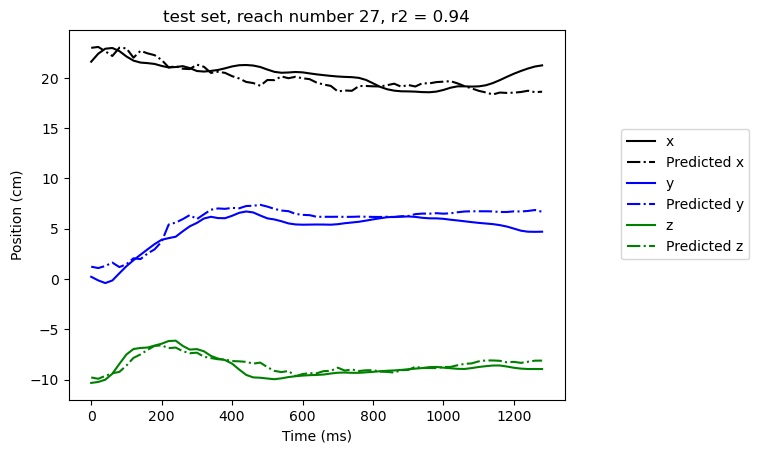

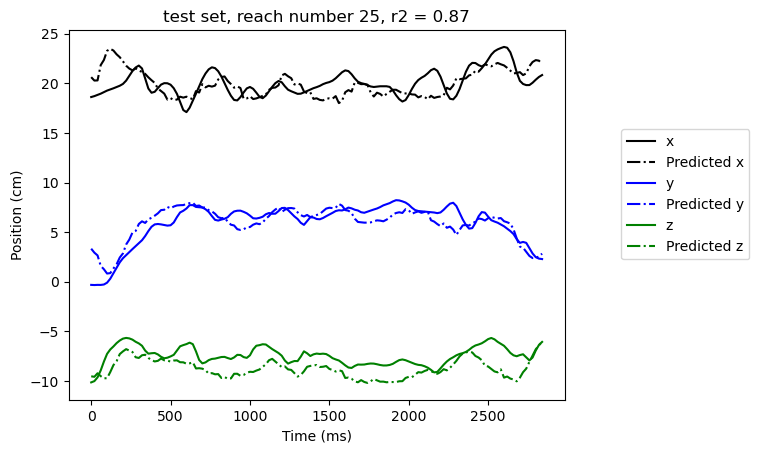

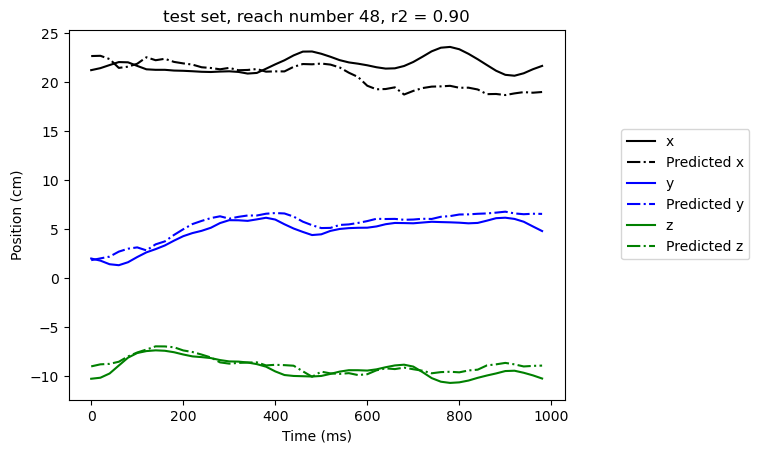

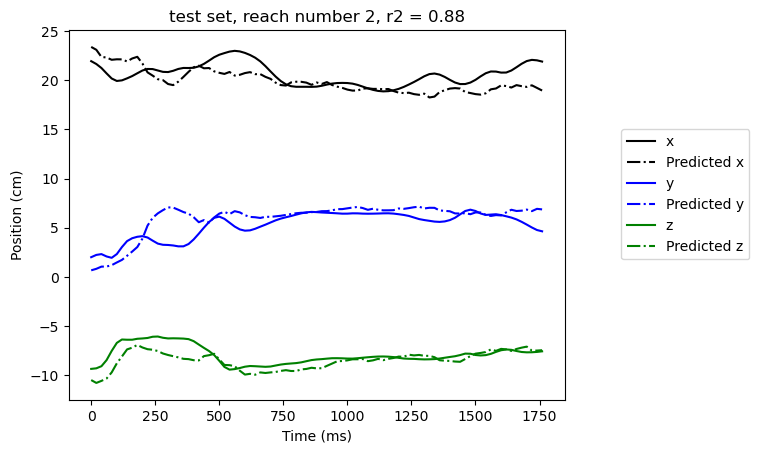

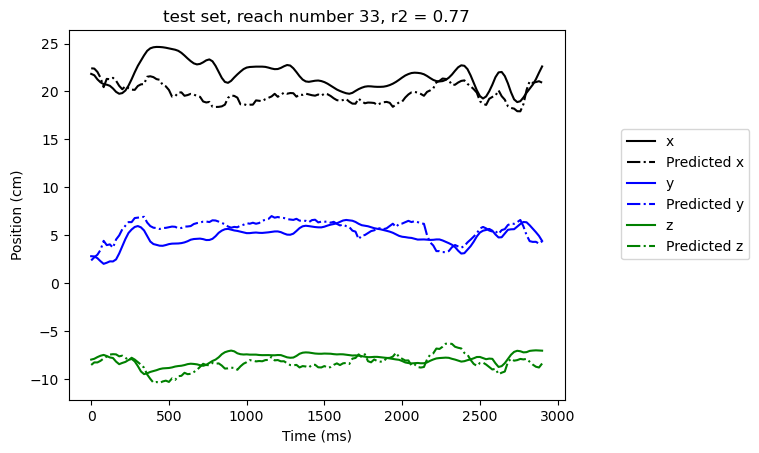

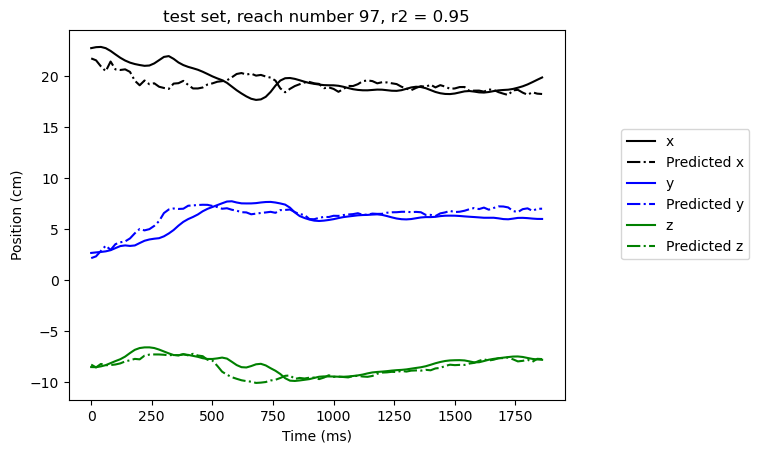

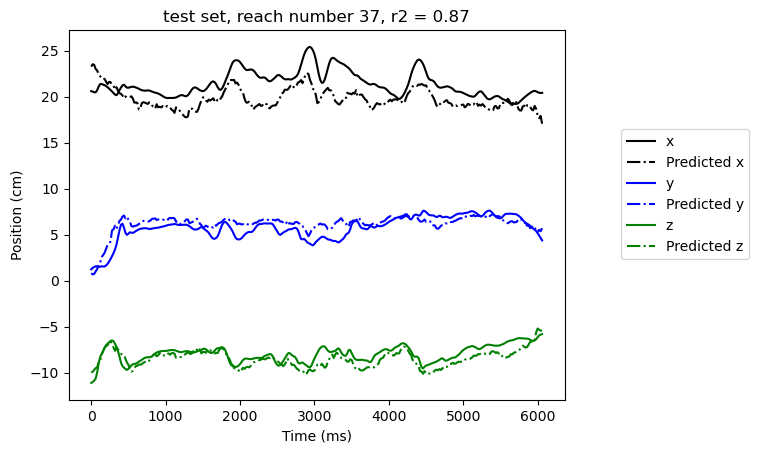

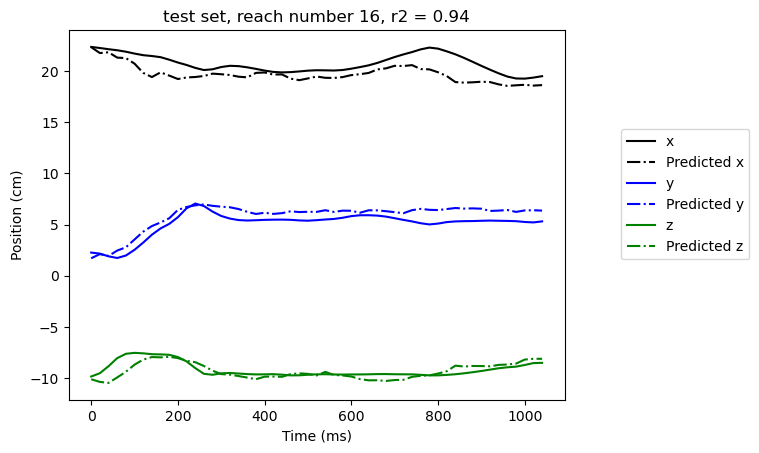

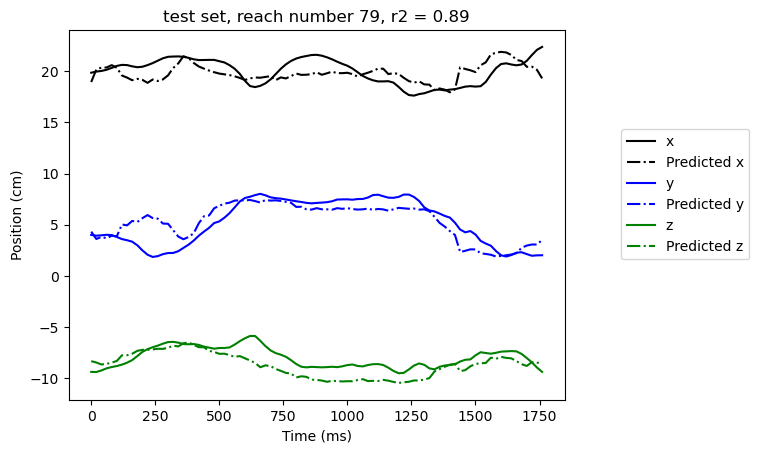

combined R2 = 0.8585092939416827


In [384]:
combined_r2 = test_set_performance(lstm_model, spikes_test, pos_test, sequence_bins, decoder_lead_bins, spikes_t0_bin, device, plot=True)
print(f'combined R2 = {combined_r2}')